In [1]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from tensorflow.keras.datasets import imdb
from konlpy.tag import Twitter  # konlpy 설치필요
from konlpy.tag import Okt
from konlpy.tag import Kkma 
from konlpy.tag import Twitter
from pprint import pprint
import nltk   # 설치 필요
from nltk.classify.scikitlearn import SklearnClassifier
from wordcloud import WordCloud, STOPWORDS      # wordcloud 설치필요
from gensim import corpora, models      # 설치필요
import numpy  as np
from PIL import Image
from wordcloud import ImageColorGenerator
import glob
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline


## 1. Char코드 기반의 NLP
### 유니코드
- 각 글자들은 아스키 코드를 갖고 있음.
- 코드값의 범위가 있기 때문에 범위를 보고 대충 어떤 언어인지 알 수 있음
- 영어와 한글은 범위가 다르기 때문에 범위만 보고 분류가 가능하지만
- 같은 알파벳을 쓰는 영어와 스페인어는 분류가 불가
- 유니코드는 총 65536개이기 때문에 어떤 문자든 한 글자당 65536차원 배열을 가짐

### 한국어, 일어, 영어, 중국어 인식

In [2]:
# 학습 전용 데이터 준비하기

ko_str = '이것은 한국어 문장입니다.'
ja_str = 'これは日本語 文章です。'
en_str = 'This is English Sentences.'
ch_str = '统一码'

In [5]:
print(ko_str[0])

이


### ord() 
> Return the Unicode code point for a one-character string.

In [6]:
#  숫자값들의 분포가 확연하게 다름을 알 수 있음
print(ord(ko_str[0]))
print(ord(ja_str[0]))
print(ord(en_str[0]))
print(ord(ch_str[0]))

51060
12371
84
32479


In [7]:
# Unicode 코드 포인트로 출현 빈도 판정하는 함수 만들기
def count_codePoint(str):
    
    counter = np.zeros(65535)   # Unicode 코드 포인트를 저장할 배열 준비하기
    
    for i in range(len(str)):    # 각 문자를 Unicode 코드 포인트로 변환하기
        code_point = ord(str[i])
        if code_point > 65535 :
            continue
            
        counter[code_point] += 1    # 출현 횟수 세기
        
    counter = counter/len(str)     # 각 요소를 문자 수로 나눠 정규화하기
    
    return counter

In [8]:
x_train = [count_codePoint(ko_str),
           count_codePoint(ja_str),
           count_codePoint(en_str)]
y_train = ['ko','ja','en']

In [17]:
print(x_train[0])
print(np.where((x_train[0] > 0)))
print('\n')

idx = np.where((x_train[0] > 0))
data = x_train[0]

print(data[idx])


[0. 0. 0. ... 0. 0. 0.]
(array([   32,    46, 44163, 44397, 45768, 45796, 47928, 50612, 51008,
       51060, 51077, 51109, 54620], dtype=int64),)


[0.14285714 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857]


### 1.1 GaussianNB 분류기
- 평균(mean), 표준편차(standard deviation)을 이용
    - 데이터들끼리 거리를 모두 비교하는 K-nearest Neighbor) 방법도 있지만 overfitting이 심해서 잘 안쓰고 Gaussian을 씀

- 정규화해서
    - 샘플데이터를 평균으로 모델링해서
    - class간에 평균, 표준편차를 이용해서
    - 데이터가 어느 class에 가까운지 ㅣ교하기
    - 정규화해서 mean, standard deviation을 구하면 -> 확률값을 구할 수 있음
    - class간 속할 확률을 구해서, 큰 쪽으로 분류하면 됌
    
- 학습시킨다는 의미
    - 평균, 분산을 구한다는 의미
    - 데이터가 1개면 그 데이터가 평균이 됌
    - K-nearest Neighbors 학습이 필요 없음
    
- y 값
    - 딥러닝에서 err를 계산하기 위해 반드시 숫자였어야 함.
    - 이 분류기에서는 참고하는 역할만 하기 때문에 숫자가 아니어도 됌

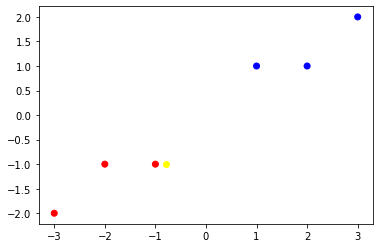

In [25]:
#X = np.array([[-1, -1], [3, 2]])
#Y = np.array([1,  2])

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
Y = np.array([1, 1, 1, 2, 2, 2])
Y2 = ['r', 'r', 'r', 'b', 'b', 'b']


color = [ 'red' if y == 1 else 'blue' for y in Y]

plt.scatter(X[:, 0], X[:, 1], color=color)

t = np.array([[-0.8, -1]])

plt.scatter(t[:,0], t[:,1], color='yellow')

In [27]:
clf = GaussianNB()
clf.fit(X,Y)
print(clf.predict([[-0.8, -1]]))
print(clf.predict([[2.5, 1.3], [0,0]]))
print('\n')

clf.fit(X,Y2)
print(clf.predict([[-0.8, -1]]))
print(clf.predict([[2.5, 1.3], [0,0]]))

[1]
[2 1]


['r']
['b' 'b']


---

In [28]:
# 학습하기 --- (*6)
clf = GaussianNB() 
clf.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [40]:
y_pred = clf.predict([count_codePoint('')])
print(y_pred)

['en']


In [33]:
# 평가 전용 데이터 준비하기
ko_test_str = '안녕. 어디야'
ja_test_str = 'こんにちは'
en_test_str = 'Hello'
x_test = [count_codePoint(en_test_str),count_codePoint(ja_test_str),count_codePoint(ko_test_str)]
y_test = ['en', 'ja', 'ko']

# 평가하기 --- (*7)
y_pred = clf.predict(x_test)
print(y_pred)
print("정답률 = " , accuracy_score(y_test, y_pred))

['en' 'ja' 'ko']
정답률 =  1.0


In [41]:
# 평가 전용 데이터 준비하기
ko_test_str = '안녕'
ja_test_str = 'こんにちは'
en_test_str = 'Hello'
x_test = [count_codePoint(en_test_str),count_codePoint(ja_test_str),count_codePoint(ko_test_str)]
y_test = ['en', 'ja', 'ko']

# 평가하기 --- (*7)
y_pred = clf.predict(x_test)
print(y_pred)
print("정답률 = " , accuracy_score(y_test, y_pred))

['en' 'ja' 'ja']
정답률 =  0.6666666666666666


---

- 문자set이 동일한 경우

In [42]:
# 학습 데이터 준비하기 --- (*1)
x_train = []
y_train = []
for file in glob.glob('./train/*.txt'):
    # 언어 정보를 추출하고 레이블로 지정하기 --- (*2)
    print(file)
    y_train.append(file[8:10])
    
    # 파일 내부의 문자열을 모두 추출한 뒤 빈도 배열로 변환한 뒤 입력 데이터로 사용하기 --- (*3)
    file_str = ''
    for line in open(file, 'r', encoding='UTF8'):
        file_str = file_str + line
    x_train.append(count_codePoint(file_str))

./train\de_cat.txt
./train\de_dog.txt
./train\de_elephant.txt
./train\en_cat.txt
./train\en_dog.txt
./train\en_elephant.txt
./train\es_cat.txt
./train\es_dog.txt
./train\es_elephant.txt


In [43]:
# 학습하기
clf = GaussianNB() 
clf.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [46]:
# 평가하기
y_pred = clf.predict([count_codePoint('hello. my name is ')])
print(y_pred)

['de']
